# Tasks for section F
***

In [1]:
%matplotlib inline

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import esda

import geopandas as gpd
import contextily as cx
import pysal
import libpysal
from pysal.lib import examples
from pysal.lib import weights
from libpysal.io import open as psopen
from libpysal.examples import load_example
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation



# Task 1: Get the dataset ready

With the ahah table on your figertips, complete all the other bits required for the ESDA analysis of spatial autocorrelation:

* Make sure your geography does not have islands
* Create a spatial weights matrix
* Standardise the spatial weights matrix
* Create the standardised version of the AHAH score
* Create the spatial lag of the main AHAH score


In [2]:
import os
from pathlib import Path

In [3]:
cwd = os.getcwd()
root = Path(cwd).parents[0].parents[0]
D_dir = str(Path(root)) + '/Hand-Ins/bD/'
#datadir = str(Path(root)) + str('/data')
#outputdir = str(Path(root)) + str('/figures')
print("Root: " + str(root))

Root: /Users/marcosdemetry/Dropbox/IFN/Programming/Python_projects/GDS-Course


In [4]:
os.chdir(D_dir)
lsoas = gpd.read_file("data/Access_to_Healthy_Assets_and_Hazards_AHAH/Local_Authority_Districts/E08000012/shapefiles/E08000012.shp")
ahah_data = pd.read_csv("data/Access_to_Healthy_Assets_and_Hazards_AHAH/Local_Authority_Districts/E08000012/tables/E08000012.csv")
ahah = lsoas.join(ahah_data.set_index("lsoa11cd"), on="lsoa11cd")
os.chdir(cwd)

<AxesSubplot:>

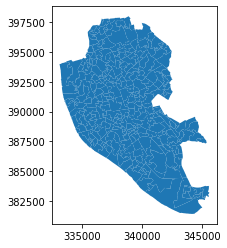

In [5]:
ahah.plot()

In [6]:
ahah.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 51 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   lsoa11cd      298 non-null    object  
 1   geometry      298 non-null    geometry
 2   lsoa11nm      298 non-null    object  
 3   r_rank        298 non-null    int64   
 4   h_rank        298 non-null    int64   
 5   g_rank        298 non-null    int64   
 6   e_rank        298 non-null    int64   
 7   r_exp         298 non-null    float64 
 8   h_exp         298 non-null    float64 
 9   g_exp         298 non-null    float64 
 10  e_exp         298 non-null    float64 
 11  ahah          298 non-null    float64 
 12  r_ahah        298 non-null    int64   
 13  d_ahah        298 non-null    int64   
 14  r_dec         298 non-null    int64   
 15  h_dec         298 non-null    int64   
 16  g_dec         298 non-null    int64   
 17  e_dec         298 non-null    int64   
 18  gp

** Note on choosing metric for spatial weights. Since the AHAH score is a measure of neighborhood "healthiness", and one could argue that access to health and hazard elements may be geographically related rather than following administrative borders. Therefore, we construct a distance based spatial weights matrix.

In [7]:
#w = weights.Queen.from_dataframe(ahah, idVariable="lsoa11cd")
w = weights.DistanceBand.from_dataframe(ahah, 1000, binary=False)

/Users/marcosdemetry/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/data.py:119: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)
/Users/marcosdemetry/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


Checking to see if we have islands:

/Users/marcosdemetry/opt/anaconda3/lib/python3.7/site-packages/geopandas/plotting.py:607: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


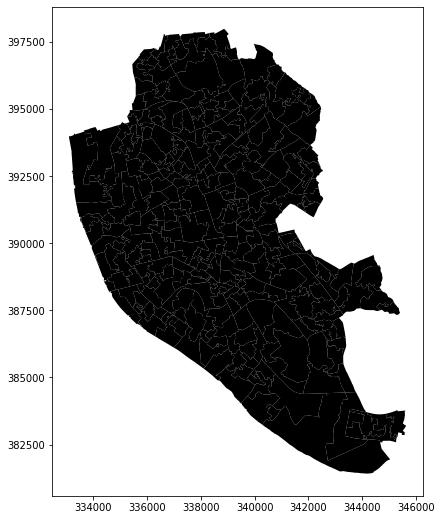

In [27]:
ax = ahah.plot(color='k', figsize=(9, 9))
ahah.loc[w.islands, :].plot(color='red', ax=ax);
plt.show()

In [9]:
ahah = ahah.drop(w.islands)

In [10]:
w = weights.DistanceBand.from_dataframe(ahah, 1000, binary=False)

/Users/marcosdemetry/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/data.py:119: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)
/Users/marcosdemetry/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [11]:
# Row standardize the matrix
w.transform = 'R'

In [12]:
ahah['w_ahah'] = weights.lag_spatial(w, ahah['ahah'])

In [13]:
ahah[['lsoa11cd', 'ahah', 'w_ahah']].head()

,lsoa11cd,ahah,w_ahah
0,E01006512,26.870382,30.183831
1,E01006513,46.542967,34.150592
2,E01006514,38.256588,32.282300
3,E01006515,27.819724,34.535282
4,E01006518,28.315099,24.990270


In [14]:
ahah['ahah_std'] = (ahah['ahah'] - ahah['ahah'].mean()) / ahah['ahah'].std()

In [15]:
ahah['w_ahah_std'] = weights.lag_spatial(w, ahah['ahah_std'])

# Task 2: Global Spatial Autocorrelation

* Visualise the main AHAH score with a Moran Plot
* Calculate Moran’s I
* What conclusions can you reach from the Moran Plot and Moran’s I? What’s the main spatial pattern?


## Moran Plot of AHAH score 

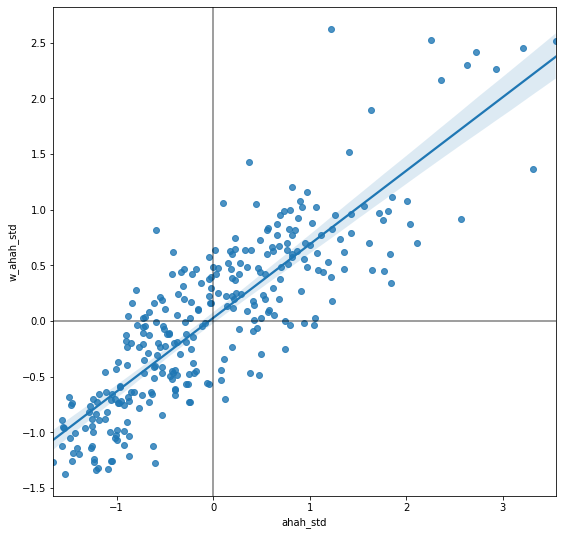

In [16]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='ahah_std', y='w_ahah_std', data=ahah)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

## Calculating Moran's I

In [17]:
mi = esda.Moran(ahah['ahah_std'], w)

In [18]:
mi.I

0.6606201636780303

In [19]:
mi.p_sim

0.001

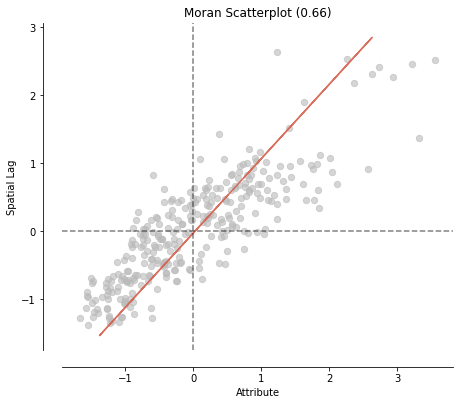

In [20]:
moran_scatterplot(mi, aspect_equal=True);

## Reflection

From the Moran plot we can see that there is a positive spatial autocorrelation. We also found the Moran's I to be 0.66 and statistically significantly different from what we would expect had the data been generated by a random process. This implies that there is clustering of AHAH, i.e., neighborhoods with high (low) values of AHAH tend to be surrounded by neighborhoods of high (low) values of AHAH. Recall that AHAH stands for Access to Healthy Assets and Hazards, and that a high value of AHAH reflects how "unhealthy" an LSOA neighborhood is. For this reason, it is not surprising that neighborhoods in Liverpool show some degree of clustering in terms of health. 

# Task 3: Local Spatial Autocorrelation

* Calculate LISA statistics for the LSOA areas
* Make a map of significant clusters at the 5%
* Can you identify hotspots or coldspots? If so, what do they mean? What about spatial outliers?
* Create cluster maps for significance levels 1% and 10%; compare them with the one we obtained. What are the main changes? Why?

In [21]:
lisa = esda.Moran_Local(ahah['ahah'], w)

In [22]:
def sign(significance_level):
    
    # Break observations into significant or not
    ahah['significant'] = lisa.p_sim < significance_level
    # Store the quadrant they belong to
    ahah['quadrant'] = lisa.q
    
    return ahah

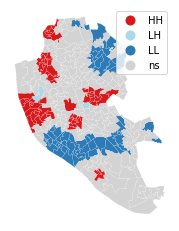

In [23]:
ahah = sign(0.05)
lisa_cluster(lisa, ahah);

## Comparing LISA at 1%, 5% and 10% significance levels

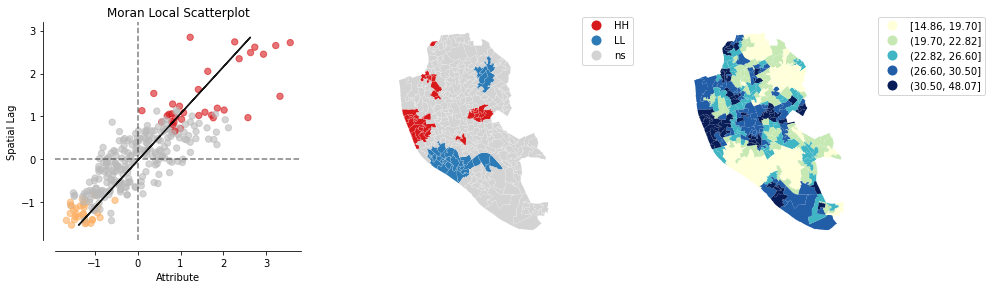

In [24]:
plot_local_autocorrelation(lisa, ahah, 'ahah', p=0.01);

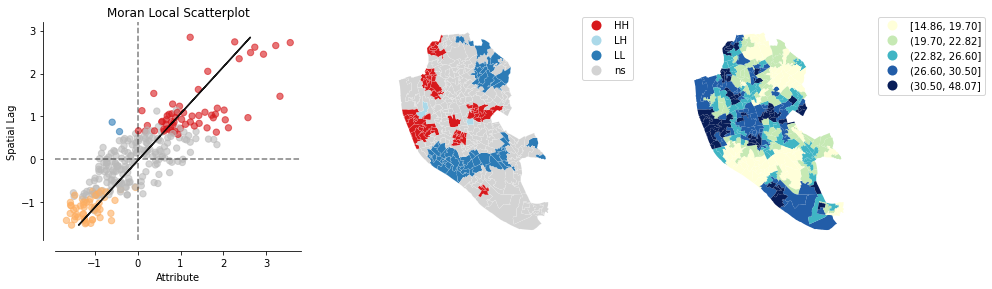

In [25]:
plot_local_autocorrelation(lisa, ahah, 'ahah', p=0.05);

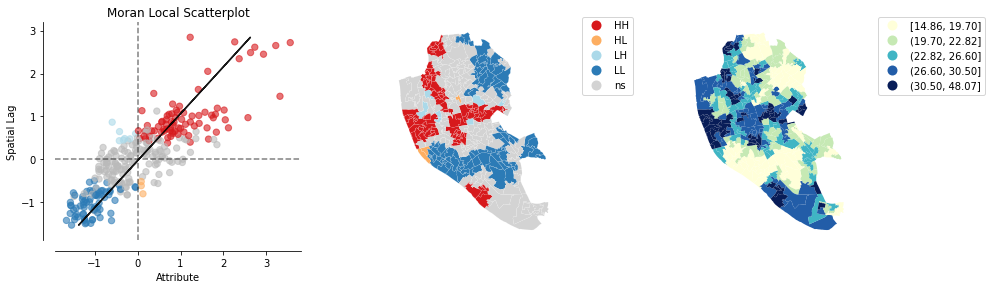

In [26]:
plot_local_autocorrelation(lisa, ahah, 'ahah', p=0.10);

## Reflection

Comparing LISA at the 1%, 5% and 10% level, we see a few things. First, we see that Moran's I (which shows global clustering) is unchanged. What we have changed, however, is the number of neighborhoods that display local clusters that one would not expect to see had the AHAH data been randomly distributed over all neighborhoods. At a 1% level, we are very restrictive and 3 big clusters (one hot spot and two cold spot) are identified. At this significance level, there are no spatial outliers. The more we relax the significance level, the bigger the clusters. At the 10% significance level, wee see 3 big clusters of hotspots and two big clusters of coldspots.